

<img src="https://dailyblogging.org/wp-content/uploads/2020/09/a_b_testing.png" width=1600 height=800 />

# Comparing Conversion Rates of AB Testing and Bidding Methods

<div style="text-align: justify"> AB testing, also known as split testing, is a statistical method used to compare two or more variations of a web page or app feature to determine which one performs better in terms of user engagement or conversion rate. It involves dividing the audience into different groups and presenting each group with a different variation, then analyzing the results to make data-driven decisions about which variation is more effective. AB testing is widely used in marketing and product development to optimize user experiences and maximize desired outcomes. </div>

### Dataset Information & Objective

This dataset contains information about a company's website, including data on the number of ad views, ad clicks, and associated earnings. The dataset is divided into two separate sets: the Control group, where Maximum Bidding was applied, and the Test group, where Average Bidding was implemented. The goal is to compare the performance of the two bidding methods to determine which one yields better results in terms of user engagement and revenue generation.

- Impression : The number of times the ads were displayed or viewed by users
- Click      : The number of times users clicked on the displayed ads after viewing them
- Purchase   : The number of times users made purchases after clicking on the ads
- Earning    : The revenue generated from the purchases made 

### Imported Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
                        pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### Defined Functions

In [2]:
def uniqueInfos(df):
    
    dictz = {"FEATURES": df.columns,
             "N_UNIQUE": [df[item].nunique() for item in df.columns],
             "N_NULL": [df[item].isnull().sum() for item in df.columns],
             "ITEMS": [df[item].unique() for item in df.columns],
             "TYPE" : [df[item].dtype for item in df.columns]}
    
    return pd.DataFrame(data = dictz)

In [3]:
file_list = [file for file in os.listdir(os.getcwd()) if ".xlsx" in file]
file_list

['ab_testing.xlsx']

Let's read  all the data & take a look!

In [4]:
df_control = pd.read_excel(file_list[0], sheet_name="Control Group")
df_test    = pd.read_excel(file_list[0], sheet_name="Test Group")

Let's merge the two datasets while adding a Group column to dataframe to analyze the data together!

In [5]:
df_control["Group"] = "Control"
df_test["Group"] = "Test"
df = pd.concat([df_control, df_test]).reset_index(drop = True)

In [6]:
uniqueInfos(df)

,FEATURES,N_UNIQUE,N_NULL,ITEMS,TYPE
0,Impression,80,0,"[82529.45927124521, 98050.45192639381, 82696.0...",float64
1,Click,80,0,"[6090.077316567174, 3382.861786182413, 4167.96...",float64
2,Purchase,80,0,"[665.2112548893001, 315.0848949727512, 458.083...",float64
3,Earning,80,0,"[2311.277142626756, 1742.806855469844, 1797.82...",float64
4,Group,2,0,"[Control, Test]",object


In [7]:
df.head()

,Impression,Click,Purchase,Earning,Group
0,82529.45927,6090.07732,665.21125,2311.27714,Control
1,98050.45193,3382.86179,315.08489,1742.80686,Control
2,82696.02355,4167.96575,458.08374,1797.82745,Control
3,109914.40040,4910.88224,487.09077,1696.22918,Control
4,108457.76263,5987.65581,441.03405,1543.72018,Control


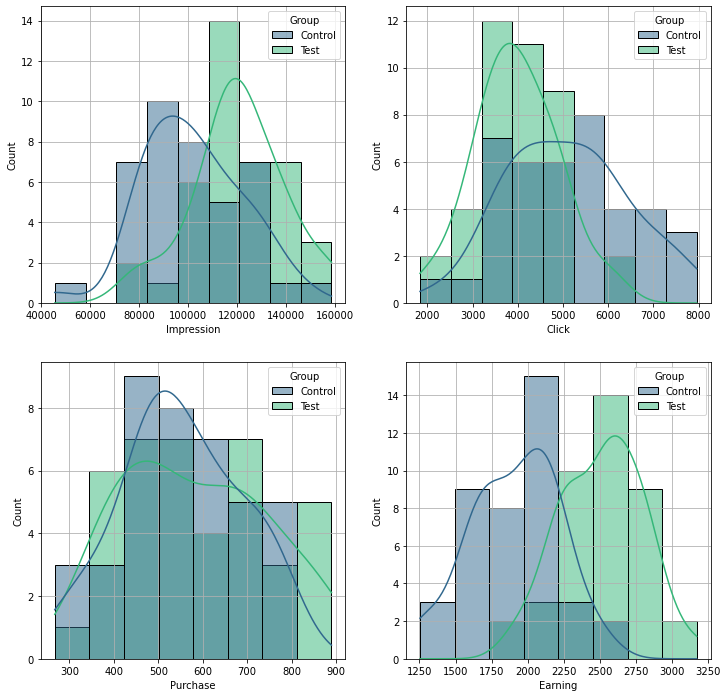

In [8]:
fig, axes = plt.subplots(2, 2, figsize = (12, 12))
w = 0
for i in range(2):
    for j in range(2):
            sns.histplot(data = df, 
                 x = df.columns[w], 
                 hue = "Group", 
                 alpha = 0.5, 
                 kde = True,
                 ax = axes [i, j],
                 palette = "viridis")
            axes[i, j].grid(True)
            w = w+1

It looks like Purchase distributions are quite close to normal both bidding strategies. To be exactly sure whether it makes a difference or not, one must apply A/B testing!

### AB Testing

First step of AB testing is to form an hypothesis. The hypothesis for the AB testing comparing the Maximum Bidding (Control) and Average Bidding (Test) techniques on the Purchase column can be stated as follows:


Null Hypothesis (H0): There is no significant difference in the average number of purchases between the Control (Maximum Bidding) and Test (Average Bidding) groups.

Alternative Hypothesis (H1): There is a significant difference in the average number of purchases between the Control (Maximum Bidding) and Test (Average Bidding) groups.


In other words:

H0: μ_control = μ_test

H1: μ_control ≠ μ_test

Where:

μ_control is the population mean of purchases for the Control group (Maximum Bidding).
μ_test is the population mean of purchases for the Test group (Average Bidding).
The null hypothesis assumes that there is no real difference in the purchase rates between the two bidding techniques, while the alternative hypothesis suggests that there is a significant difference in purchase rates between the two bidding techniques. 
Before conducting the AB testing, it is essential to check the assumptions to ensure the validity of the test results. The two main assumptions to verify are:

#### 1. Normality Check:

The data in each group should be approximately normally distributed. We can use the Shapiro-Wilk test for normality.

In [9]:
control_group = df[df['Group'] == 'Control']['Purchase']
test_group = df[df['Group'] == 'Test']['Purchase']

# Shapiro-Wilk test for normality
_, p_value_control = shapiro(control_group)
_, p_value_test = shapiro(test_group)

# Print p-values
print("Shapiro-Wilk Test - Control Group: p =", p_value_control)
print("Shapiro-Wilk Test - Test Group:    p =", p_value_test)


Shapiro-Wilk Test - Control Group: p = 0.5891178250312805
Shapiro-Wilk Test - Test Group:    p = 0.1541350930929184


p-values for both of the groups are above the value of 0.05 (p > 0.05). Hence the Normality checks out! 

Null hypothesis CAN'T be rejected !

#### 2. Homogeneity of Variance: 

The variances of the data in the two groups should be approximately equal. We can use the Levene's test for homogeneity of variance.

In [10]:
_, p_value_levene = levene(control_group, test_group)

# Print p-value
print("Levene's Test - p =", p_value_levene)

Levene's Test - p = 0.10828588271874791


Levene's test yielded a p-value of 0.1, which is greater than the typical significance level of 0.05, it indicates that there is no significant difference in variances between the two groups. In this case, we can proceed with the standard independent two-sample t-test, assuming equal variances.

#### 3. T-Test: 

In [11]:
# Perform the independent two-sample t-test assuming equal variances
t_stat, p_value = ttest_ind(control_group, test_group, equal_var=True)

print("ttest p-value : ", p_value)

# Check for statistical significance
if p_value < 0.05:
    print("There is a significant difference between Maximum Bidding and Average Bidding on the Purchase column.")
else:
    print("There is no significant difference between Maximum Bidding and Average Bidding on the Purchase column.")

ttest p-value :  0.34932579202108416
There is no significant difference between Maximum Bidding and Average Bidding on the Purchase column.


### Conclusion

<div style="text-align: justify">In this analysis, we compared the Maximum Bidding and Average Bidding methods on the Purchase column using an independent two-sample t-test, which showed no significant difference between the two techniques. To optimize overall campaign success, we recommend diversifying bidding strategies, exploring other key performance indicators, and continuously A/B testing to adapt to changing market dynamics and platform algorithms. </div>